Text Classification with Various Neural Networks

**Description:** For the context of classification, lets compare Deep Averaging Networks, Deep Weighted Averaging Networks using Attention, and BERT-based models, using the IMDB dataset. This notebook should be run on a Google Colab leveraging a GPU. 

The overall structure is as follows:


1. Setup
  
  1.1 Libraries, Embeddings,  & Helper Functions

  1.2 Data Acquisition

  1.3. Data Preparation

      1.3.1 Training/Test Sets using Word2Vec

      1.3.2 Training/Test Sets for BERT-based models


2. Classification with various Word2Vec-based Models

  2.1 The Role of Shuffling of the Training Set

  2.2 DAN vs Weighted Averaging Models using Attention

    2.2.1 Warm-Up
    
    2.2.2 The WAN Model
    
  2.3 Approaches for Training of Embeddings


3. Classification with BERT

  3.1. BERT Basics

  3.2 CLS-Token-based Classification

  3.3 Averaging of BERT Outputs

  3.4. Adding a CNN on top of BERT


## 1. Setup

### 1.1. Libraries and Helper Functions

This notebook requires the TensorFlow dataset and other prerequisites.

In [1]:
#@title Installs

!pip install pydot --quiet
!pip install gensim --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text --quiet
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 17.9 MB/s eta 0:00:00


Now we are ready to do the imports.

In [2]:
#@title Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel
from transformers import logging
logging.set_verbosity_error()

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import datapath

Below is a helper function to plot histories.

In [3]:
#@title Plotting Function

# 4-window plot. Small modification from matplotlib examples.

def make_plot(axs,
              model_history1,
              model_history2,
              model_1_name='model 1',
              model_2_name='model 2',
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
        if 'classification_%s' % metric in model_history2.history:
            metric2 = 'classification_%s' % metric
        else:
            metric2 = metric

        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric2])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.9

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric2])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.1

        for j, model_history in enumerate([model_history1, model_history2]):
            model_name = [model_1_name, model_2_name][j]
            model_metric = [metric, metric2][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[model_metric])
            ax1.plot(model_history.history['val_%s' % model_metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

Next, we get the word2vec model from nltk.

In [4]:
#@title NLTK & Word2Vec

nltk.download('word2vec_sample')

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))

wvmodel = KeyedVectors.load_word2vec_format(datapath(word2vec_sample), binary=False)

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


let's see how many words are in the vocabulary of the embedding **model**:

In [ ]:
len(wvmodel)

43981

What do the word vectors look like? As expected:

In [ ]:
wvmodel['great'][:20]

array([ 0.0306035 ,  0.0886877 , -0.0121269 ,  0.0761965 ,  0.0566269 ,
       -0.0424702 ,  0.0410129 , -0.0497567 , -0.00364328,  0.0632889 ,
       -0.0142608 , -0.0791111 ,  0.0174877 , -0.0383064 ,  0.00926433,
        0.0295626 ,  0.0770293 ,  0.0949334 , -0.0428866 , -0.0295626 ],
      dtype=float32)

We can now build the embedding matrix and a vocabulary dictionary:

In [5]:
EMBEDDING_DIM = len(wvmodel['university'])      # we know... it's 300

# initialize embedding matrix and word-to-id map:
embedding_matrix = np.zeros((len(wvmodel) + 1, EMBEDDING_DIM))
vocab_dict = {}

# build the embedding matrix and the word-to-id map:
for i, word in enumerate(wvmodel.index_to_key):
    embedding_vector = wvmodel[word]

    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        vocab_dict[word] = i

# we can use the last index at the end of the vocab for unknown tokens
vocab_dict['[UNK]'] = len(vocab_dict)

In [53]:
embedding_matrix.shape

(43982, 300)

In [54]:
embedding_matrix[:5, :5]

array([[ 0.0891758 ,  0.121832  , -0.0671959 ,  0.0477279 , -0.013659  ],
       [ 0.0526281 ,  0.013157  , -0.010104  ,  0.0540819 ,  0.0386715 ],
       [ 0.0786419 ,  0.0373911 , -0.0131472 ,  0.0347375 ,  0.0288273 ],
       [-0.00157585, -0.0564239 ,  0.00320281,  0.0422498 ,  0.15264399],
       [ 0.0356899 , -0.00367283, -0.065534  ,  0.0213832 ,  0.00788408]])

The last row consists of all zeros. We will use that for the UNK token, the placeholder token for unknown words.

### 1.2 Data Acquisition


We will use the IMDB dataset delivered as part of the TensorFlow-datasets library, and split into training and test sets. For expedience, we will limit ourselves in terms of train and test examples.

In [6]:
train_data, test_data = tfds.load(
    name="imdb_reviews",
    split=('train[:80%]', 'test[80%:]'),
    as_supervised=True)

train_examples, train_labels = next(iter(train_data.batch(20000)))
test_examples, test_labels = next(iter(test_data.batch(5000)))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete65AASE/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete65AASE/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete65AASE/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Lets takea  look at the records:

In [ ]:
train_examples[:4]

<tf.Tensor: shape=(4,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell a

In [ ]:
train_labels[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 1])>

For convenience, we will define a sequence length and truncate all records at that length. For records that are shorter than our defined sequence length we will add padding characters to insure that our input shapes are consistent across all records.

In [41]:
MAX_SEQUENCE_LENGTH = 100

## 1.3. Data Preparation

### 1.3.1. Training/Test Sets for Word2Vec-based Models

First, we tokenize the data:

In [42]:
tokenizer = tf_text.WhitespaceTokenizer()
train_tokens = tokenizer.tokenize(train_examples)
test_tokens = tokenizer.tokenize(test_examples)

Let's look at some tokens:

In [43]:
train_tokens[0]

<tf.Tensor: shape=(116,), dtype=string, numpy=
array([b'This', b'was', b'an', b'absolutely', b'terrible', b'movie.',
       b"Don't", b'be', b'lured', b'in', b'by', b'Christopher', b'Walken',
       b'or', b'Michael', b'Ironside.', b'Both', b'are', b'great',
       b'actors,', b'but', b'this', b'must', b'simply', b'be', b'their',
       b'worst', b'role', b'in', b'history.', b'Even', b'their', b'great',
       b'acting', b'could', b'not', b'redeem', b'this', b"movie's",
       b'ridiculous', b'storyline.', b'This', b'movie', b'is', b'an',
       b'early', b'nineties', b'US', b'propaganda', b'piece.', b'The',
       b'most', b'pathetic', b'scenes', b'were', b'those', b'when',
       b'the', b'Columbian', b'rebels', b'were', b'making', b'their',
       b'cases', b'for', b'revolutions.', b'Maria', b'Conchita',
       b'Alonso', b'appeared', b'phony,', b'and', b'her', b'pseudo-love',
       b'affair', b'with', b'Walken', b'was', b'nothing', b'but', b'a',
       b'pathetic', b'emotional', b

Next, we define a simple function that converts the tokens above into the appropriate word2vec index values.   

In [9]:
def docs_to_vocab_ids(tokenized_texts_list):
    """
    converting a list of strings to a list of lists of word ids
    """
    texts_vocab_ids = []
    text_labels = []
    valid_example_list = []
    for i, token_list in enumerate(tokenized_texts_list):

        # Get the vocab id for each token in this doc ([UNK] if not in vocab)
        vocab_ids = []
        for token in list(token_list.numpy()):
            decoded = token.decode('utf-8', errors='ignore')
            if decoded in vocab_dict:
                vocab_ids.append(vocab_dict[decoded])
            else:
                vocab_ids.append(vocab_dict['[UNK]'])

        # Truncate text to max length, add padding up to max length
        vocab_ids = vocab_ids[:MAX_SEQUENCE_LENGTH]
        n_padding = (MAX_SEQUENCE_LENGTH - len(vocab_ids))
        # For simplicity in this model, we'll just pad with unknown tokens
        vocab_ids += [vocab_dict['[UNK]']] * n_padding
        # Add this example to the list of converted docs
        texts_vocab_ids.append(vocab_ids)

        if i % 5000 == 0:
            print('Examples processed: ', i)

    print('Total examples: ', i)
    return np.array(texts_vocab_ids)

Now we can create training and test data that can be fed into the models of interest.  We need to convert all of the tokens in to their respective input ids.

In [50]:
train_input_ids = docs_to_vocab_ids(train_tokens)
test_input_ids = docs_to_vocab_ids(test_tokens)

train_input_labels = np.array(train_labels)
test_input_labels = np.array(test_labels)

Examples processed:  0
Examples processed:  5000
Examples processed:  10000
Examples processed:  15000
Total examples:  19999
Examples processed:  0
Total examples:  4999


Double checking that the data looks correct:

In [51]:
train_input_ids[:2]

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958],
       [12139,  7841, 19666, 31757, 43981, 17853, 25745, 15445, 43981,
        19123, 35029, 16908, 21113, 21068, 43981, 43981,  5668, 43981,
        33456, 43981, 34554, 43981,  1200, 27498, 43981, 1880

### 1.3.2. Training/Test Sets for BERT-based models

Let's load the pretrained BERT model and tokenizer. 

In [55]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Next, we will preprocess our train and test data for use in the BERT model. We need to convert our documents into vocab IDs, like we did above with the Word2Vec vocabulary. But this time we'll use the BERT tokenizer, which has a different vocabulary specific to the BERT model we're going to use.

In [ ]:
#@title BERT Tokenization of training and test data

train_examples_str = [x.decode('utf-8') for x in train_examples.numpy()]
test_examples_str = [x.decode('utf-8') for x in test_examples.numpy()]

bert_train_tokenized = bert_tokenizer(train_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(train_labels)

bert_test_tokenized = bert_tokenizer(test_examples_str,
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                     bert_test_tokenized.token_type_ids,
                     bert_test_tokenized.attention_mask]
bert_test_labels = np.array(test_labels)

key variables and sets that we encoded for word2vec and BERT:

#### Parameters:

* MAX_SEQUENCE_LENGTH (100)


#### Word2vec-based models:

* train(/test)_input_ids: input ids for the training(/test) sets for word2vec models
* train(/test)_input_labels: the corresponding labels

#### BERT:


* bert_train(/test)_inputs: list of input_ids, token_type_ids and attention_mask for the training(/test) sets for BERT models
* bert_train(/test)_labels: the corresponding labels for BERT

### 1.4  Keras Functional API warm up

Initial model: 

In [ ]:
input_x = Input(shape = (MAX_SEQUENCE_LENGTH,), name="input_words")


#define dense layers
dense_1 = keras.layers.Dense(300, activation='relu', name='hidden1')
dense_2 = keras.layers.Dense(200, activation='relu', name='hidden2')
dense_3 = keras.layers.Dense(5, activation='relu', name='output')

# Define the input layer

embedding_layer = Embedding(embedding_matrix.shape[0],
                               embedding_matrix.shape[1],
                               embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                               input_length=MAX_SEQUENCE_LENGTH,
                               trainable=False, name='embedding')
an_embeddings = embedding_layer(input_x)
an_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='lambda')(an_embeddings)

dense_1_out = dense_1(an_avg_embeddings)
dense_2_out = dense_2(dense_1_out)
dense_3_out = dense_3(dense_2_out)


model = tf.keras.models.Model(inputs=input_x, outputs=[dense_3_out ], name='a2_question1')

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:

model.summary()

Model: "a2_question1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_words (InputLayer)    [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 300)          13194600  
                                                                 
 lambda (Lambda)             (None, 300)               0         
                                                                 
 hidden1 (Dense)             (None, 300)               90300     
                                                                 
 hidden2 (Dense)             (None, 200)               60200     
                                                                 
 output (Dense)              (None, 5)                 1005      
                                                                 
Total params: 13346105 (50.91 MB)
Trainable params: 15

## 2. Classification with various Word2Vec-based Models

2.a. Checking if the dataset is balanced:

In [ ]:

p = np.sum(train_input_labels == 1)
(p/train_input_labels.shape)[0]






0.49845



2.b. Percentage of positive examples in the test set. 

In [ ]:

p = np.sum(test_input_labels == 1)
(p/test_input_labels.shape)[0]


0.5026

### 2.1 Shuffling of the Training Set


The DAN model.

In [ ]:
def create_dan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Constructing the DAN model including the compilation and returning it. Parametrizing it using the arguments.
  :param retrain_embeddings: boolean, indicating whether  the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'

  # start by creating the dan_embedding_layer. Use the embeddings_initializer. 
  dan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64')
  dan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                    embedding_matrix.shape[1],
                                    #embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    embeddings_initializer = embeddings_initializer,
                                    input_length=max_sequence_length,
                                    trainable = retrain_embeddings )


  dan_embeddings = dan_embedding_layer(dan_input_layer)
  dan_avg_embeddings = tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1), name='averaging')(dan_embeddings)




  last_hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu',
                                                   name='dan_hidden_1')(dan_avg_embeddings)

  last_hidden_output = tf.keras.layers.Dropout(dropout)(last_hidden_output)

  dan_classification = tf.keras.layers.Dense(1,
                                               activation='sigmoid',
                                               name='dan_classification')(last_hidden_output)
  dan_model = tf.keras.models.Model(inputs=dan_input_layer, outputs=[dan_classification])
  #dan_model.compile(loss='binary_crossentropy',
  #                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,
  #                                                       beta_1=0.9,
  #                                                       beta_2=0.999,
  #                                                       epsilon=1e-07,
  #                                                       amsgrad=False,
  #                                                       name='Adam'), metrics='accuracy')
  dan_model.compile(loss='binary_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    metrics='accuracy')


  return dan_model

sorted version of the training dataset to run some simulations:

In [13]:
sorted_train_input_data = [(x, y) for (x, y) in zip(list(train_input_ids), list(train_input_labels))]
sorted_train_input_data.sort(key = lambda x: x[1])
sorted_training_input_ids = np.array([x[0] for x in sorted_train_input_data])
sorted_training_labels = np.array([x[1] for x in sorted_train_input_data])

create the DAN model using the default parameters and train it:




In [ ]:
dan_model_sorted = create_dan_model()
#use dan_sorted_history = ... below
dan_sorted_history = dan_model_sorted.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids, test_input_labels),
                                          batch_size=32,
                                          epochs=10, #was 10
                                          shuffle=False
                                          )


Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.3388 - accuracy: 0.9098 - val_loss: 1.8503 - val_accuracy: 0.5026
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6394 - accuracy: 0.7269 - val_loss: 1.7409 - val_accuracy: 0.5026
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6004 - accuracy: 0.7538 - val_loss: 1.2609 - val_accuracy: 0.5026
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5735 - accuracy: 0.7445 - val_loss: 1.1968 - val_accuracy: 0.5026
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5763 - accuracy: 0.7361 - val_loss: 1.1463 - val_accuracy: 0.5026
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.5503 - accuracy: 0.7349 - val_loss: 1.7774 - val_accuracy: 0.5026
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.6049 - accuracy: 0.7473 - val_loss: 1.2371 - val_accuracy: 0.5026
Epoch 

Recreating the same model and training it with **'shuffle=True'**. (Note that this is also the default.). Using 'dan_shuffled_history' for the history.

In [ ]:


dan_model_shuffled = create_dan_model()
dan_shuffled_history = dan_model_shuffled.fit(sorted_training_input_ids,
                                              sorted_training_labels,
                                              validation_data=(test_input_ids, test_labels),
                                              batch_size=32,
                                              epochs=10, #was 10
                                              shuffle = True
                                              )



Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 0.6448 - accuracy: 0.6443 - val_loss: 0.5992 - val_accuracy: 0.6884
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5553 - accuracy: 0.7273 - val_loss: 0.5419 - val_accuracy: 0.7278
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5228 - accuracy: 0.7440 - val_loss: 0.5252 - val_accuracy: 0.7388
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5082 - accuracy: 0.7545 - val_loss: 0.5184 - val_accuracy: 0.7438
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5001 - accuracy: 0.7581 - val_loss: 0.5165 - val_accuracy: 0.7434
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4957 - accuracy: 0.7598 - val_loss: 0.5097 - val_accuracy: 0.7542
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4903 - accuracy: 0.7638 - val_loss: 0.5063 - val_accuracy: 0.7560
Epoch 

Comparing the 2 histories in a plot.

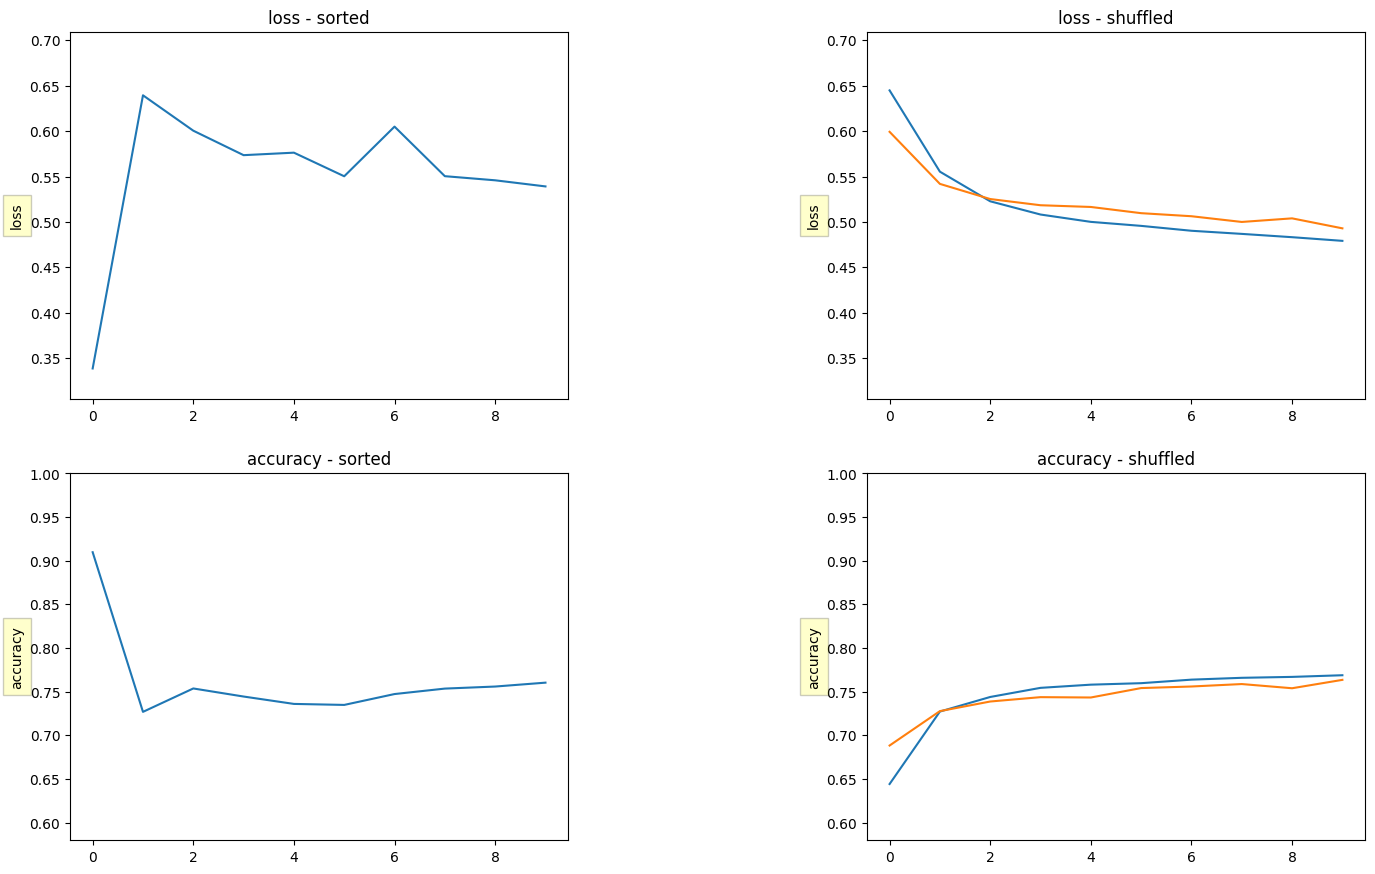

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_sorted_history,
          dan_shuffled_history,
          model_1_name='sorted',
         model_2_name='shuffled')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

### 2.2 DAN vs Weighted Averaging Models using Attention

#### 2.2.1. Manual Attention Calculation



In [ ]:
q = [1, 2., 1]

k1 = v1 = [-1, -1, 3.]
k2 = v2 = [1, 2, -5.]

In [ ]:

import tensorflow as tf

# Define the query, keys, and values
q = tf.constant([[1., 2., 1.]])  # the query
k = tf.constant([[-1., -1., 3.], [1., 2., -5.]])  # the keys
v = tf.constant([[-1., -1., 3.], [1., 2., -5.]])  # the values

# Add an extra dimension to the query
q = tf.expand_dims(q, 1)

# Create an Attention layer
attention_layer = tf.keras.layers.Attention()

# Call the Attention layer with the query, keys, and values
context_vector = attention_layer([q, k, v], return_attention_scores = True)

print(context_vector)




(<tf.Tensor: shape=(1, 1, 3), dtype=float32, numpy=array([[[ 0. ,  0.5, -1. ]]], dtype=float32)>, <tf.Tensor: shape=(1, 1, 2), dtype=float32, numpy=array([[[0.5, 0.5]]], dtype=float32)>)


#### 2.2.2 The 'WAN' Model


Next, we would like to improve our DAN by attempting to train a neural net that learns to put more weight on some words than others by using **Attention**.



The critical change from the DAN is to add a learnable query vector for the attention calculation.

The key vectors should be the incoming word vectors.

The query vector needs to have the size of the word vectors, as it needs to attend to them. We generate an embedding like vector by getting a single row of trained weights from a Dense layer, if we pass in a value of one to multiply by that weight matrix:


```
wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
```

We use a 'fake input-like layer' that creates for each incoming batch example a '1', that then the query layer can get applied to.

```
wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
```

The query vector becomes available for each example:

```
wan_query_vector = wan_query_layer(wan_batch_of_ones)

```

We will also have **2 outputs**

We should use:

```
tf.keras.layers.Attention()
```

We need 2 outputs that makes the classification.

Finally, we reshape the output after the Attention layer, because the Attention layer gives a sequence of vectors for each example. It will just be a sequence of one weighted average vector for each example. We want to remove that middle dimension of size to just have a single vector for each example. 

```
wan_attention_output = tf.keras.layers.Reshape((wan_attention_output.shape[-1],))(wan_attention_output)
```

In [ ]:
def create_wan_model(retrain_embeddings=False,
                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                     hidden_dim=100,
                     dropout=0.3,
                     embedding_initializer='word2vec',
                     learning_rate=0.001):
  """
  Constructing the WAN model including the compilation and returning it. Parametrizing it using the arguments.
  :param retrain_embeddings: boolean, indicating whether the word embeddings are trainable
  :param hidden_dim: dimension of the hidden layer
  :param dropout: dropout applied to the hidden layer

  :returns: the compiled model
  """

  if embedding_initializer == 'word2vec':
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix)
  else:
    embeddings_initializer='uniform'



  wan_input_layer = tf.keras.layers.Input(shape=(max_sequence_length,), dtype='int64', name='wan_input_layer')
  wan_embedding_layer = Embedding(embedding_matrix.shape[0],
                                  embedding_matrix.shape[1],
                                  embeddings_initializer=embeddings_initializer,
                                  input_length=max_sequence_length,
                                  trainable = retrain_embeddings )
  wan_embeddings = wan_embedding_layer(wan_input_layer)
  #attention layers
  wan_one_vector = tf.Variable(tf.ones((1, 1, 1)))
  wan_batch_of_ones = tf.tile(wan_one_vector, (tf.shape(wan_input_layer)[0], 1, 1))
  wan_query_layer = tf.keras.layers.Dense(embedding_matrix.shape[1])
  wan_query_vector = wan_query_layer(wan_batch_of_ones)
  #end attention layers
  wan_attention_output = tf.keras.layers.Attention()([wan_query_vector, wan_embeddings, wan_embeddings], return_attention_scores = True)
  wan_attention = tf.keras.layers.Reshape((wan_attention_output[0].shape[-1],), name ='wan_attention_weights')(wan_attention_output[0])

  last_hidden_output = tf.keras.layers.Dense(hidden_dim, activation='relu')(wan_attention)
  last_hidden_output_dropout = tf.keras.layers.Dropout(dropout)(last_hidden_output)
  #classificatioin layer
  wan_classification = tf.keras.layers.Dense(1,activation='sigmoid', name='classification')(last_hidden_output_dropout)
 # Get the attention weights
  wan_model = tf.keras.models.Model(inputs=wan_input_layer, outputs=[wan_classification, wan_attention_output[1]])

 
  wan_model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                    loss=['binary_crossentropy', None],
                    metrics=[['accuracy'], None]
                     )







  return wan_model


Train the model for the same dataset as the DAN model (shuffled data) and saving its history in a variable named 'wan_history'.

In [ ]:
wan_model = create_wan_model()


wan_history = wan_model.fit(sorted_training_input_ids,
                                              sorted_training_labels,
                                              validation_data=(test_input_ids, test_labels),
                                              batch_size=32,
                                              epochs=10,
                                              shuffle = True
                                              )



Epoch 1/10
625/625 [==============================] - 5s 6ms/step - loss: 0.5749 - classification_loss: 0.5749 - classification_accuracy: 0.6994 - val_loss: 0.4983 - val_classification_loss: 0.4983 - val_classification_accuracy: 0.7578
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4846 - classification_loss: 0.4846 - classification_accuracy: 0.7670 - val_loss: 0.4822 - val_classification_loss: 0.4822 - val_classification_accuracy: 0.7704
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4686 - classification_loss: 0.4686 - classification_accuracy: 0.7771 - val_loss: 0.4778 - val_classification_loss: 0.4778 - val_classification_accuracy: 0.7668
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4612 - classification_loss: 0.4612 - classification_accuracy: 0.7814 - val_loss: 0.4669 - val_classification_loss: 0.4669 - val_classification_accuracy: 0.7776
Epoch 5/10
625/625 [==============================] - 4s

Now we compare the results of the initial dan_model training and the wan_model training:

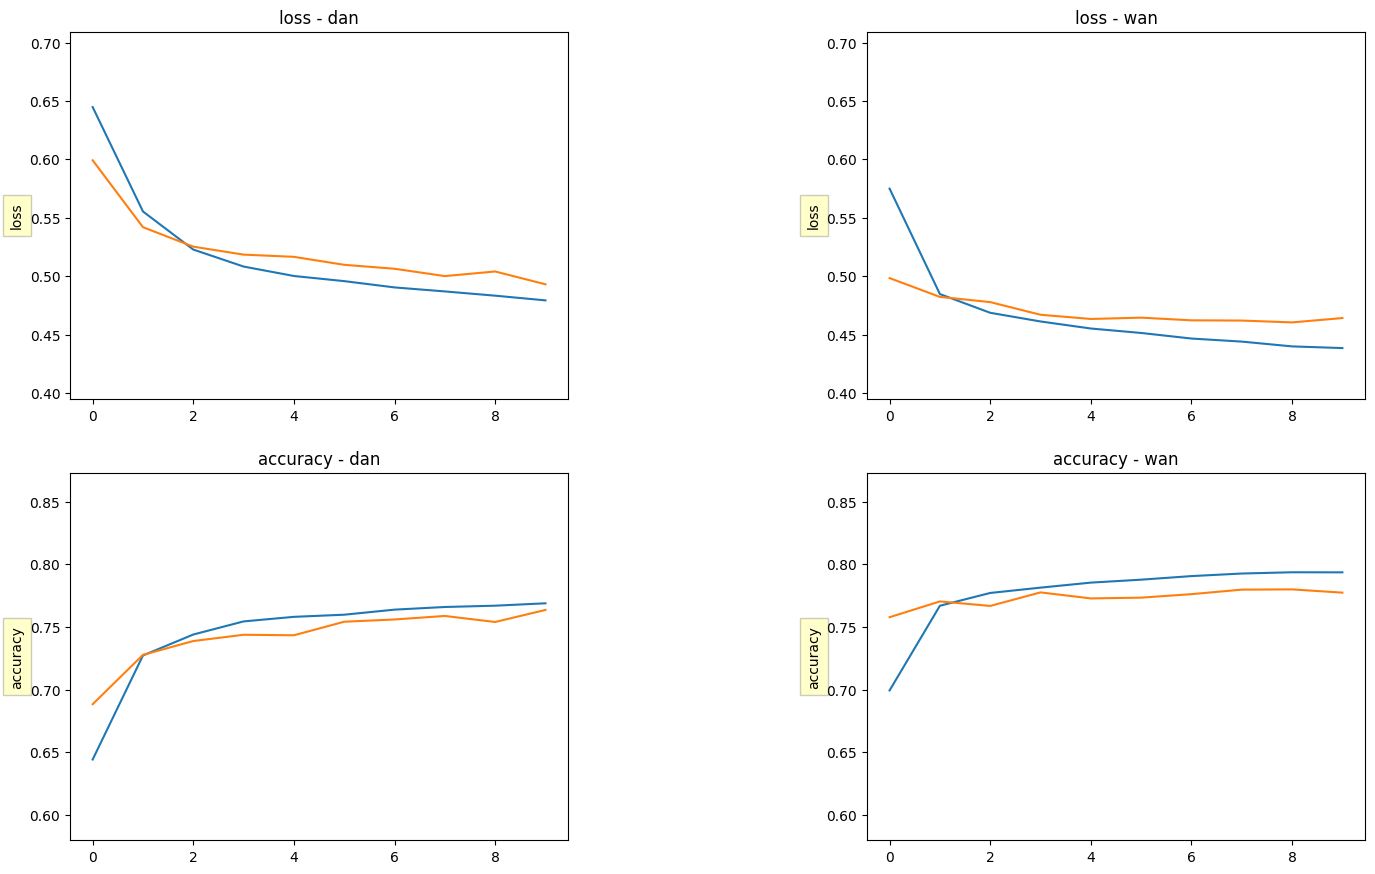

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs,
          dan_shuffled_history,
          wan_history,
          model_1_name='dan',
         model_2_name='wan')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

Next, let us see for the wan_model which words matter most for the classification prediction and which ones did less so by looking at the attention weights.

In [ ]:
train_examples[0].numpy().decode('utf-8')

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

The corresponding list of input ids that are suitably formatted, i.e. with sequence length 100, are these:

In [ ]:
probe_input_ids = train_input_ids[:1]
probe_input_ids

array([[21531, 25272, 12291,  7427, 37254, 43981,  6891, 12917, 38232,
        16915, 12929, 16182, 43981, 20526, 23487, 43981, 23807, 42958,
        35058, 43981, 19123, 35029, 41270, 29275, 12917, 32597, 20659,
          638, 16915, 43981,   174, 32597, 35058, 39971,  2326,  3636,
        22434, 35029, 43981, 33922, 43981, 21531, 34710, 16908, 12291,
        36880, 28137,  5376, 28038, 43981, 15402, 29155, 18063, 24951,
        17433, 17595,  8856, 14193, 43981, 43248, 17433,  6290, 32597,
         9001, 11511, 43981, 21807, 39168, 43981, 16856, 43981, 43981,
        23245, 43981,  8889,  1331, 43981, 25272, 31976, 19123, 43981,
        18063, 36309, 24099, 16915, 43981, 34710, 36633, 25272, 20413,
        43981, 33458, 14926, 43981, 12139, 12289, 39617, 36633,  9483,
        42958]])

and the first 10 corresponding tokens are:

In [ ]:
probe_tokens = [x.decode('utf-8') for x in train_tokens[0].numpy()][:100]
probe_tokens[:10]

['This',
 'was',
 'an',
 'absolutely',
 'terrible',
 'movie.',
 "Don't",
 'be',
 'lured',
 'in']

Identifying the **5 words** with the highest impact and the **5 words** with the lowest impact on the score:

In [ ]:


# 'pairs' should be the variable that holds the  token/weight pairs.
at_weights = wan_model.predict(probe_input_ids[:1])[1][0][0]
pairs = [(token, weight) for token, weight in zip(probe_tokens, at_weights)]
#sort by weight in descending order
pairs.sort(key=lambda x: x[1], reverse=True)






print('most important tokens:')
print('\t', pairs[:10])
print('\nleast important tokens:')
print('\t', pairs[-10:])



1/1 [==============================] - 0s 149ms/step
most important tokens:
	 [('worst', 0.1103431), ('terrible', 0.081310354), ('pathetic', 0.050736107), ('pathetic', 0.050736107), ('devoid', 0.037530296), ('ridiculous', 0.033721156), ('nothing', 0.030627105), ('simply', 0.02234307), ('must', 0.02109732), ('emotional', 0.02038935)]

least important tokens:
	 [('their', 0.001924269), ('their', 0.001924269), ('their', 0.001924269), ('I', 0.0018410002), ('this', 0.0017834926), ('this', 0.0017834926), ('am', 0.0017749646), ('The', 0.0016681406), ('her', 0.0016647222), ('the', 0.0014193867)]


### 2.3 Approaches for Training of Embeddings

Rerunning the DAN Model in 3 separate configurations:


1.   embedding_initializer = 'word2vec' and retrain_embeddings=False
2.   embedding_initializer = 'word2vec' and retrain_embeddings=True
3.   embedding_initializer = 'uniform' and retrain_embeddings=True



In [ ]:

#run once
dan_model_one = create_dan_model()
#use dan_sorted_history = ... below
dan_one_history = dan_model_one.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids, test_input_labels),
                                          batch_size=32,
                                          epochs=10,
                                          shuffle=True
                                          )




Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6388 - accuracy: 0.6525 - val_loss: 0.5899 - val_accuracy: 0.7102
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5515 - accuracy: 0.7281 - val_loss: 0.5408 - val_accuracy: 0.7270
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5211 - accuracy: 0.7436 - val_loss: 0.5301 - val_accuracy: 0.7338
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5100 - accuracy: 0.7529 - val_loss: 0.5157 - val_accuracy: 0.7504
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4998 - accuracy: 0.7581 - val_loss: 0.5208 - val_accuracy: 0.7440
Epoch 6/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4944 - accuracy: 0.7618 - val_loss: 0.5053 - val_accuracy: 0.7560
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4906 - accuracy: 0.7635 - val_loss: 0.5053 - val_accuracy: 0.7586
Epoch 

In [ ]:

#run once
dan_model_two = create_dan_model(retrain_embeddings=True)
#use dan_sorted_history = ... below
dan_two_history = dan_model_two.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids, test_input_labels),
                                          batch_size=32,
                                          epochs=3,
                                          shuffle=True
                                          )





Epoch 1/3
625/625 [==============================] - 278s 442ms/step - loss: 0.5032 - accuracy: 0.7495 - val_loss: 0.4494 - val_accuracy: 0.7880
Epoch 2/3
625/625 [==============================] - 222s 355ms/step - loss: 0.3178 - accuracy: 0.8694 - val_loss: 0.4596 - val_accuracy: 0.7900
Epoch 3/3
625/625 [==============================] - 236s 378ms/step - loss: 0.2368 - accuracy: 0.9082 - val_loss: 0.5369 - val_accuracy: 0.7772


In [ ]:


#run once
dan_model_three = create_dan_model(retrain_embeddings=True, embedding_initializer = 'uniform')
#use dan_sorted_history = ... below
dan_three_history = dan_model_three.fit(sorted_training_input_ids,
                                          sorted_training_labels,
                                          validation_data=(test_input_ids, test_input_labels),
                                          batch_size=32,
                                          epochs=3,
                                          shuffle=True
                                          )




Epoch 1/3
625/625 [==============================] - 253s 403ms/step - loss: 0.5092 - accuracy: 0.7469 - val_loss: 0.4407 - val_accuracy: 0.7914
Epoch 2/3
625/625 [==============================] - 204s 326ms/step - loss: 0.3216 - accuracy: 0.8626 - val_loss: 0.4873 - val_accuracy: 0.7768
Epoch 3/3
625/625 [==============================] - 211s 338ms/step - loss: 0.2362 - accuracy: 0.9078 - val_loss: 0.5234 - val_accuracy: 0.7718



## 3. BERT-based Classification Models

We will perform classifications with various models that are based on pre-trained BERT models.


### 3.1. Basics

lets load the pretrained BERT model and tokenizer that we'll use (
'bert-base-cased').

In [18]:
test_input = ['this bank is closed on Sunday', 'the steepest bank of the river is dangerous']

Lets tokenize it:

In [15]:
tokenized_input = bert_tokenizer(test_input,
                                 max_length=12,
                                 truncation=True,
                                 padding='max_length',
                                 return_tensors='tf')

tokenized_input

{'input_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[ 101, 1142, 3085, 1110, 1804, 1113, 3625,  102,    0,    0,    0,
           0],
       [ 101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249,  102,
           0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 12), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]], dtype=int32)>}

In [24]:


bert_output = bert_model(tokenized_input)
bert_output



TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 12, 768), dtype=float32, numpy=
array([[[ 0.03282782, -0.12895375, -0.32560351, ..., -0.01338751,
         -0.21460207, -0.27648538],
        [ 0.03282776, -0.12895384, -0.32560351, ..., -0.01338752,
         -0.21460205, -0.27648544],
        [ 0.03282782, -0.12895371, -0.32560357, ..., -0.01338757,
         -0.21460213, -0.27648544],
        ...,
        [ 0.03282783, -0.1289537 , -0.32560351, ..., -0.01338751,
         -0.2146021 , -0.27648547],
        [ 0.03282782, -0.12895375, -0.32560357, ..., -0.01338758,
         -0.21460213, -0.27648556],
        [ 0.03282783, -0.12895373, -0.32560354, ..., -0.01338752,
         -0.21460204, -0.27648544]],

       [[ 0.03288053, -0.1290081 , -0.3256126 , ..., -0.0134043 ,
         -0.21461979, -0.27647457],
        [ 0.03288062, -0.12900816, -0.32561263, ..., -0.01340434,
         -0.21461979, -0.2764746 ],
        [ 0.03288063, -0.1290082 , -0.3256127 , ..

3.1.b Check outputs:



In [25]:


print('Shape BERT output zero: ', bert_output[0].shape)
print('Shape BERT output one: ', bert_output[1].shape)




Shape BERT output zero:  (2, 12, 768)
Shape BERT output one:  (2, 768)


We use the first output to get token-level embeddings.



In [ ]:
bert_tokenizer.encode('bank')

[101, 3085, 102]

In [ ]:
tokenized_input['input_ids'][0].numpy().tolist()

[101, 1142, 3085, 1110, 1804, 1113, 3625, 102, 0, 0, 0, 0]

In [ ]:
tokenized_input['input_ids'][1].numpy().tolist()

[101, 1103, 9458, 2556, 3085, 1104, 1103, 2186, 1110, 4249, 102, 0]

### 3.2 CLS-Token-based Classification

We will do classification with BERT using the pooled token and extract the [CLS] token output for classification.

In [57]:
def create_bert_cls_model(bert_base_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Building a simple classification model with BERT. Using the CLS Token output for classification purposes.    """

    
    id_inputs = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_inputs')
    id_tokens = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_tokens')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_attention_mask')
    bert_inputs = {'input_ids': id_inputs, 'token_type_ids': id_tokens, 'attention_mask': attention_mask}

    bert_out = bert_base_model(bert_inputs)[0]


    cls_token = bert_out[:, 0, :]
    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden_layer)

    classification_model = tf.keras.Model(inputs=[id_inputs, id_tokens, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')




    return classification_model

Now we create the model and train for 2 epochs. Using batch size 8 and the appropriate validation/test set. 


In [59]:

classification_model = create_bert_cls_model(bert_model)

# Train the model for 2 epochs with batch size 8
classification_model.fit(bert_train_inputs, bert_train_labels, epochs=2,
                         batch_size=8,
                         validation_data=(bert_test_inputs, bert_test_labels))




Epoch 1/2


2500/2500 [==============================] - 522s 194ms/step - loss: 0.4307 - accuracy: 0.8017 - val_loss: 0.3516 - val_accuracy: 0.8428
Epoch 2/2
2500/2500 [==============================] - 485s 194ms/step - loss: 0.2934 - accuracy: 0.8831 - val_loss: 0.4201 - val_accuracy: 0.8216


### 3.3 Classification by Averaging the BERT outputs

Instead of using only the output vector for the [CLS] token, we will now average the output vectors from BERT for all of the tokens in the full sequence.





In [60]:
def create_bert_avg_model(bert_a_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size = 100,
                          dropout=0.3,
                          learning_rate=0.00005):
    """
    Building a simple classification model with BERT. Using the average of the BERT output tokens
    """




    id_inputs = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_inputs')
    id_tokens = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_tokens')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_attention_mask')
    bert_inputs = {'input_ids': id_inputs, 'token_type_ids': id_tokens, 'attention_mask': attention_mask}

    bert_out = bert_a_model(bert_inputs)[0]

    mean_output= tf.math.reduce_mean(bert_out, axis=1)

    hidden_layer = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(mean_output)

    hidden_layer = tf.keras.layers.Dropout(dropout)(hidden_layer)
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden_layer)

    classification_model = tf.keras.Model(inputs=[id_inputs, id_tokens, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 metrics='accuracy')


    

    return classification_model

Now create the model and train for 2 epochs. Use batch size 8 and the appropriate validation/test set. 

In [61]:

avg_bert_model = create_bert_avg_model(bert_model)

# Train the model with average pooling for 2 epochs with batch size 8
avg_bert_model.fit(bert_train_inputs, bert_train_labels, epochs=2, batch_size=8, validation_data=(bert_test_inputs, bert_test_labels))




Epoch 1/2


2500/2500 [==============================] - 533s 198ms/step - loss: 0.1829 - accuracy: 0.9315 - val_loss: 0.5563 - val_accuracy: 0.8244
Epoch 2/2
2500/2500 [==============================] - 479s 192ms/step - loss: 0.1111 - accuracy: 0.9617 - val_loss: 0.5792 - val_accuracy: 0.8170


### 3.4 Adding a CNN on top of BERT

We wil combine CNN with BERT

In [64]:
def create_bert_cnn_model(bert_cnn_model,
                          max_sequence_length=MAX_SEQUENCE_LENGTH,
                          num_filters = [131, 127, 51, 23, 17],
                          kernel_sizes = [2, 3, 4, 5, 7],
                          dropout = 0.3,
                          hidden_size = 275, #100
                          learning_rate=0.00005):
    """
    Building a  classification model with BERT, where we apply CNN layers to the BERT output
    """

    
    from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Dropout
    id_inputs = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_inputs')
    id_tokens = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_id_tokens')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='layer_attention_mask')
    bert_inputs = {'input_ids': id_inputs, 'token_type_ids': id_tokens, 'attention_mask': attention_mask}

    bert_output = bert_cnn_model(bert_inputs)[0]

    # CNN layers
    conv_outputs = []
    for filter_size, kernel_size in zip(num_filters, kernel_sizes):
      conv_layer = Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu')(bert_output)
      maxpool_layer = GlobalMaxPooling1D()(conv_layer)
      conv_outputs.append(maxpool_layer)

    # Concatenate the outputs of different filters
    if len(num_filters) > 1:
      cnn_output = tf.keras.layers.Concatenate()(conv_outputs)
    else:
      cnn_output = conv_outputs[0]


    dense_layer = Dense(hidden_size, activation='relu')(cnn_output)
    dropout_layer = Dropout(dropout)(dense_layer)

    output_layer = Dense(1, activation='sigmoid')(dropout_layer)  # binary classification
    classification_model = tf.keras.Model(inputs=[id_inputs, id_tokens, attention_mask], outputs=[output_layer])
    # Compile the model
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy'])








    

    return classification_model

Train this model for 2 epochs as well with mini-batch size of 8:

In [63]:

cnn_bert_model = create_bert_cnn_model(bert_model)

# Train the model with average pooling for 2 epochs with batch size 8
cnn_bert_model.fit(bert_train_inputs, bert_train_labels, epochs=2, batch_size=8, validation_data=(bert_test_inputs, bert_test_labels))





Epoch 1/2


2500/2500 [==============================] - 540s 202ms/step - loss: 0.0956 - accuracy: 0.9682 - val_loss: 0.6453 - val_accuracy: 0.8144
Epoch 2/2
2500/2500 [==============================] - 490s 196ms/step - loss: 0.0606 - accuracy: 0.9799 - val_loss: 0.7105 - val_accuracy: 0.8008
